# parPE Lucarelli example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sbml_file = 'lucarelli_12.xml'
model_name = 'lucarelli_12'
model_output_dir = 'lucarelli_12'

## Test simulation

In [3]:
def plotStateTrajectories(rdata):
    for ix in range(22,33):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


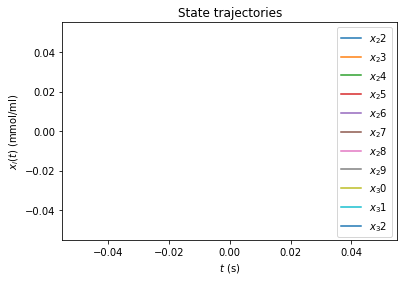

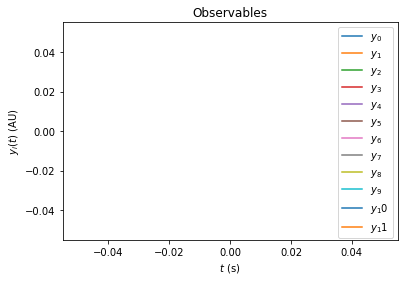

In [4]:
# load model
model_name = 'lucarelli_12'
model_output_dir = 'lucarelli_12'

sys.path.insert(0, model_output_dir)
import lucarelli_12 as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.linspace(0, 250, 25))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Prepare parameter estimation with minibatch optimizer

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [5]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'
true_parameters = default_parameters.copy()

import h5py
with h5py.File(hdf5File, 'r+') as f:
    pscale = f['/parameters/pscale'][:]
    true_parameters_scaled = true_parameters.copy()
    for i, p in enumerate(pscale):
        if p == 2:
            if true_parameters[i] < 1e-10:
                true_parameters_scaled[i] = -10.0
            else:
                true_parameters_scaled[i] = np.log10(true_parameters[i])
    
    for i in range(2):
        parameters = true_parameters_scaled
        # parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        # parameters = np.random.uniform(-8, 4, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters
        
hdf5FileMinibatch = 'example_data_minibatch.h5'
!cp {hdf5File} {hdf5FileMinibatch}

In [6]:
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s optimizer 10 # minibatch
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/maxEpochs 5
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/batchSize 1
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/parameterUpdater Adam
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/learningRateInterpMode linear
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s minibatch/rescueInterceptor 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch} -s retryOptimization 0
!../../../misc/optimizationOptions.py {hdf5FileMinibatch}

                               numStarts            1
                hierarchicalOptimization            0
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Rebuild executables

In [28]:
!pwd
!(cd ../../../build && exec make -j12)

/home/paul/Documents/parpe/parPE/amici/examples/lucarelli
[  5%] Built target parpecommon
-- Found Git: /usr/bin/git (found version "2.17.1") 
Scanning dependencies of target parpeoptimization
-- Building version parPE-v0.1.8-80-gcb17-dirty
[ 23%] Built target lucarelli_12
[ 41%] Built target model_steadystate_scaled
[ 44%] Built target unittests_common
[ 44%] Built target get_version
[ 45%] Built target simulate_model_steadystate_scaled
[ 47%] Built target parpeloadbalancer
[ 48%] Built target simulate_lucarelli_12
[ 49%] Built target example_loadbalancer
[ 49%] Building CXX object optimization/src/CMakeFiles/parpeoptimization.dir/optimizationProblem.cpp.o
[ 50%] Building CXX object optimization/src/CMakeFiles/parpeoptimization.dir/minibatchOptimization.cpp.o
[ 52%] Built target unittests_loadbalancer
/home/paul/Documents/parpe/parPE/optimization/src/optimizationProblem.cpp: In function ‘void parpe::optimizationProblemGradientCheck(parpe::OptimizationProblem*, gsl::span<const int>, do

/home/paul/Documents/parpe/parPE/optimization/src/minibatchOptimization.h:342:14: warning: unused variable ‘status’ [-Wunused-variable]
         auto status = evaluate(f, parameters, dataSpan, cost, gradient, &logger, reporter);
              ^~~~~~
/home/paul/Documents/parpe/parPE/optimization/src/minibatchOptimization.h: In instantiation of ‘parpe::FunctionEvaluationStatus parpe::MinibatchOptimizer<BATCH_ELEMENT>::rescueInterceptor(gsl::span<double>, gsl::span<double>, gsl::span<double>, gsl::span<double>, gsl::span<const double>, gsl::span<const double>, double&, int&, int, const parpe::SummedGradientFunction<T>&, std::vector<T>, parpe::Logger*, parpe::OptimizationReporter*) [with BATCH_ELEMENT = int]’:
/home/paul/Documents/parpe/parPE/optimization/src/minibatchOptimization.h:310:45:   required from ‘std::tuple<int, double, std::vector<double, std::allocator<double> > > parpe::MinibatchOptimizer<BATCH_ELEMENT>::optimize(const parpe::SummedGradientFunction<T>&, gsl::span<const T>, gs

## Minibatch optimization

In [ ]:
!mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -o deleteme-minibatch/ {hdf5FileMinibatch}


[2018-10-12 18:57:05] [INF] [0/paul-ubuntu] Running with 4 MPI processes.
[2018-10-12 18:57:05] [DBG] [0/paul-ubuntu] Rank 0/4 running on paul-ubuntu.
[2018-10-12 18:57:05] [DBG] [0/paul-ubuntu] Seeding RNG with 1539363425
[2018-10-12 18:57:05] [INF] [0/paul-ubuntu] Reading options and data from 'example_data_minibatch.h5'.
[2018-10-12 18:57:05] [DBG] [1/paul-ubuntu] Rank 1/4 running on paul-ubuntu.
[2018-10-12 18:57:05] [DBG] [1/paul-ubuntu] Seeding RNG with 1539363425
[2018-10-12 18:57:05] [DBG] [3/paul-ubuntu] Rank 3/4 running on paul-ubuntu.
[2018-10-12 18:57:05] [DBG] [2/paul-ubuntu] Rank 2/4 running on paul-ubuntu.
[2018-10-12 18:57:05] [DBG] [3/paul-ubuntu] Seeding RNG with 1539363425
[2018-10-12 18:57:05] [DBG] [2/paul-ubuntu] Seeding RNG with 1539363425
[2018-10-12 18:57:05] [DBG] [0/paul-ubuntu] Starting runParallelMultiStartOptimization with 1 starts
[2018-10-12 18:57:05] [INF] [0/paul-ubuntu] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2018-10-12 

## IpOpt optimization

In [ ]:
# enable derivate checker
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py {hdf5File} -s ipopt/derivative_test_print_all yes
!../../../misc/optimizationOptions.py {hdf5File} -s numStarts 1
!../../../misc/optimizationOptions.py {hdf5File} -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py {hdf5File}

In [ ]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 mpiexec -np 4 ../../../build/amici/examples/lucarelli/estimateLucarelli -o deleteme/ example_data.h5


In [ ]:
filename = 'deleteme/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
trajectory

## Compare results

In [ ]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [ ]:
compareResults('deleteme-minibatch/_rank-0001.h5', -expectedLlh)

In [ ]:
!pwd

In [ ]:
!rm sim.h5
!../../../build/amici/examples/lucarelli/simulateLucarelli deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

In [ ]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

In [ ]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            x = ymes[icondition, :, iy]
            y = ysim[icondition, :, iy]
            print(x, y)
            ax.scatter(x, y, label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

In [ ]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), alpha=0.7, c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)